# Postprocessing

### In this notebook we show how to retrieve the outputs of a cosmopipe likelihood fitting run.
As a general rule, any output (DataVector, CovarianceMatrix, Profiles, Samples, etc.) corresponds to a class instance that can be saved and loaded with methods save_auto, load_auto. "auto" means the difference between ASCII files (.txt) and numpy binary files (.npy) is automatic. One can also directly use save_txt/load_txt for ASCII files (save/load for numpy binary files).

In [1]:
import os

from matplotlib import pyplot as plt

import pypescript
from pypescript import BasePipeline
from pypescript.main import main

from cosmopipe.lib import setup_logging

demo_dir = '..'
setup_logging()

config_fn = os.path.join(demo_dir,'demo_linear_templatefit.yaml')
from pypescript.syntax import yaml_parser

## First run the linear template fit demo, it takes ~ 1 minute
- setup template cosmology
- compute Gaussian covariance matrix with Kaiser model
- build mock data vector (here just taken as a Gaussian realisation around the theory)
- fit mock data vector (minuit)

In [2]:
with open(config_fn,'r') as file:
    config = file.read()

config_block = yaml_parser(config)
# we just add some noise to the data vector and remove the window function effect (faster)
config_block['mockdata']['mean'] = False
config_block['projection']['$modules'] = []
main(config_block=config_block)

[000000.03] [0/1] 08-02 00:08  BasePipeline              INFO     Init module BasePipeline [main].
[000000.04] [0/1] 08-02 00:08  BaseModule                INFO     Importing module cosmopipe.theory.primordial.primordial [primordial].
[000000.38] [0/1] 08-02 00:08  BaseModule                INFO     Found description file /local/home/adematti/Bureau/DESI/NERSC/cosmopipe/cosmopipe/theory/primordial/primordial.yaml.
[000000.38] [0/1] 08-02 00:08  BaseModule                INFO     Init module Primordial [primordial].
[000000.38] [0/1] 08-02 00:08  BaseModule                INFO     Importing module cosmopipe.theory.galaxy_clustering.linear_model [model].
[000000.42] [0/1] 08-02 00:08  BaseModule                INFO     Found description file /local/home/adematti/Bureau/DESI/NERSC/cosmopipe/cosmopipe/theory/galaxy_clustering/linear_model.yaml.
[000000.42] [0/1] 08-02 00:08  BaseModule                INFO     Init module LinearModel [model].
[000000.42] [0/1] 08-02 00:08  BaseModule       

/local/home/adematti/Bureau/DESI/NERSC/lib/cosmoprimo/cosmoprimo/eisenstein_hu.py:20: UserWarning: EisensteinHuEngine cannot cope with massive neutrinos
  warnings.warn('{} cannot cope with massive neutrinos'.format(self.__class__.__name__))


[000001.08] [0/1] 08-02 00:08  MockDataVector            INFO     Saving to _data/data.txt.
[000001.11] [0/1] 08-02 00:08  GaussianLikelihood        INFO     The number of observations used to estimate the covariance matrix is not provided, hence no Hartlap factor is applied to inverse covariance.
[000001.11] [0/1] 08-02 00:08  MinuitProfiler            INFO     Running migrad for 5 iterations.
[000001.12] [0/1] 08-02 00:08  BaseTaskManager           INFO     Entering BaseTaskManager.
[000008.81] [0/1] 08-02 00:08  Profiles                  INFO     Saving to _data/profiles.npy.
[000008.81] [0/1] 08-02 00:08  Profiles                  INFO     Saving to _plots/stats_linear.tex.
[000008.97] [0/1] 08-02 00:08  Plotting                  INFO     Saving figure to _plots/aligned_stacked_linear.png.
[000009.20] [0/1] 08-02 00:08  matplotlib.mathtext       INFO     Substituting symbol \perp from STIXGeneral
[000009.21] [0/1] 08-02 00:08  matplotlib.mathtext       INFO     Substituting symbol 

## Let's look at the generated mock DataVector...

[000009.70] [0/1] 08-02 00:08  DataVector                INFO     Loading _data/data.txt.


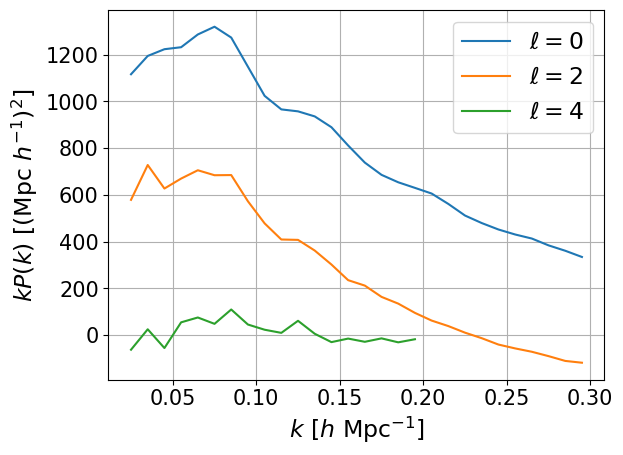

In [3]:
from cosmopipe.lib.data_vector import DataVector
data_vector = DataVector.load_txt('_data/data.txt')
ax = data_vector.plot()
plt.show()

## ... at the Gaussian covariance matrix

[000009.99] [0/1] 08-02 00:08  CovarianceMatrix          INFO     Loading _data/covariance.txt.


/local/home/adematti/Bureau/DESI/NERSC/cosmopipe/cosmopipe/lib/data_vector/plotting.py:245: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  mesh = ax.pcolor(x[1][j],x[0][i],mat[i][j].T,norm=norm,cmap=plt.get_cmap('jet_r'))


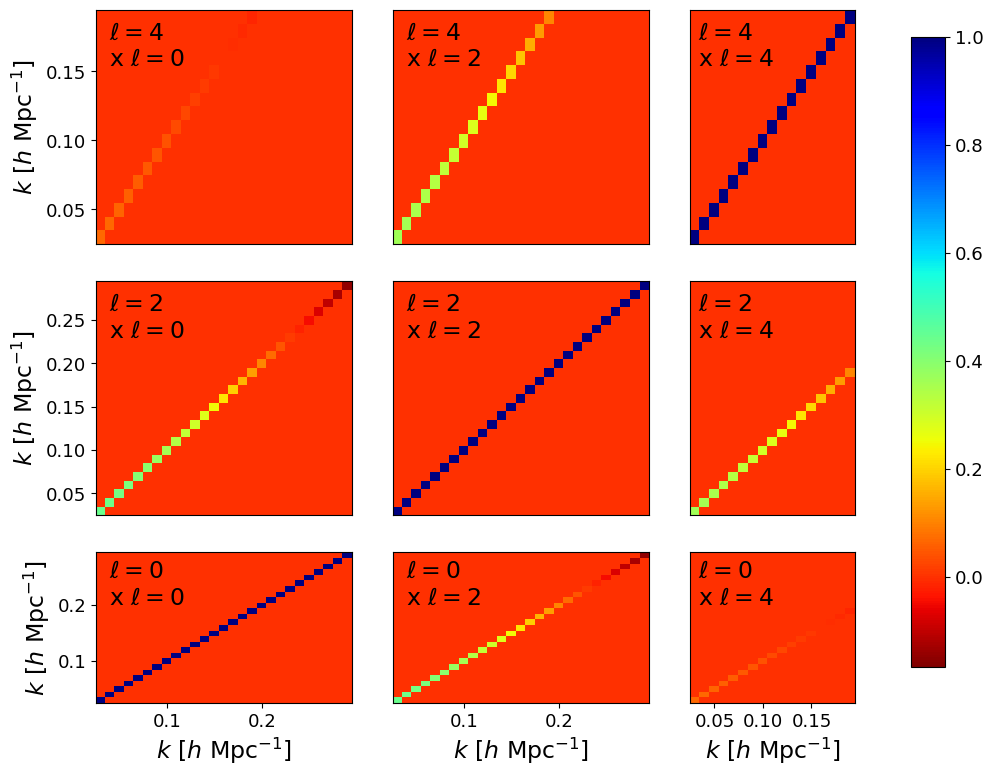

In [4]:
from cosmopipe.lib.data_vector import CovarianceMatrix
covariance = CovarianceMatrix.load_txt('_data/covariance.txt')
covariance.plot(style='corr') # corr for correlation matrix
plt.show()

Add the error bars to the data vector plot

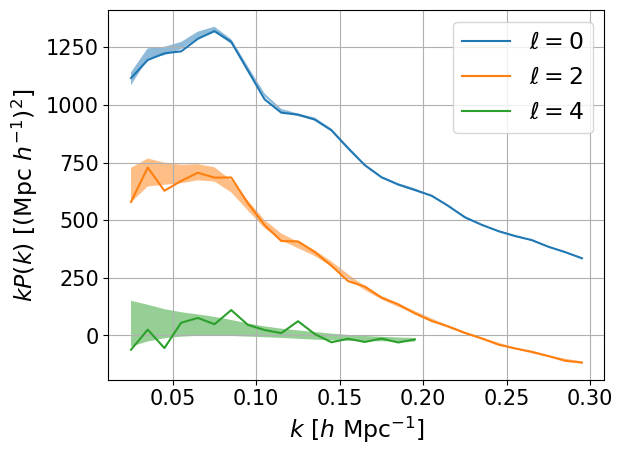

In [5]:
data_vector.plot(covariance=covariance)
plt.show()

## At the best fits (profiles as opposition to samples)

In [6]:
from cosmopipe.lib.samples import Profiles, ProfilesPlotStyle
profiles = Profiles.load('_data/profiles.npy')

[000011.13] [0/1] 08-02 00:08  Profiles                  INFO     Loading _data/profiles.npy.


All parameters are within 1 sigma of their expected value

[000011.35] [0/1] 08-02 00:08  matplotlib.mathtext       INFO     Substituting symbol \perp from STIXGeneral
[000011.35] [0/1] 08-02 00:08  matplotlib.mathtext       INFO     Substituting symbol \perp from STIXGeneral
[000011.57] [0/1] 08-02 00:08  matplotlib.mathtext       INFO     Substituting symbol \perp from STIXGeneral
[000011.57] [0/1] 08-02 00:08  matplotlib.mathtext       INFO     Substituting symbol \perp from STIXGeneral


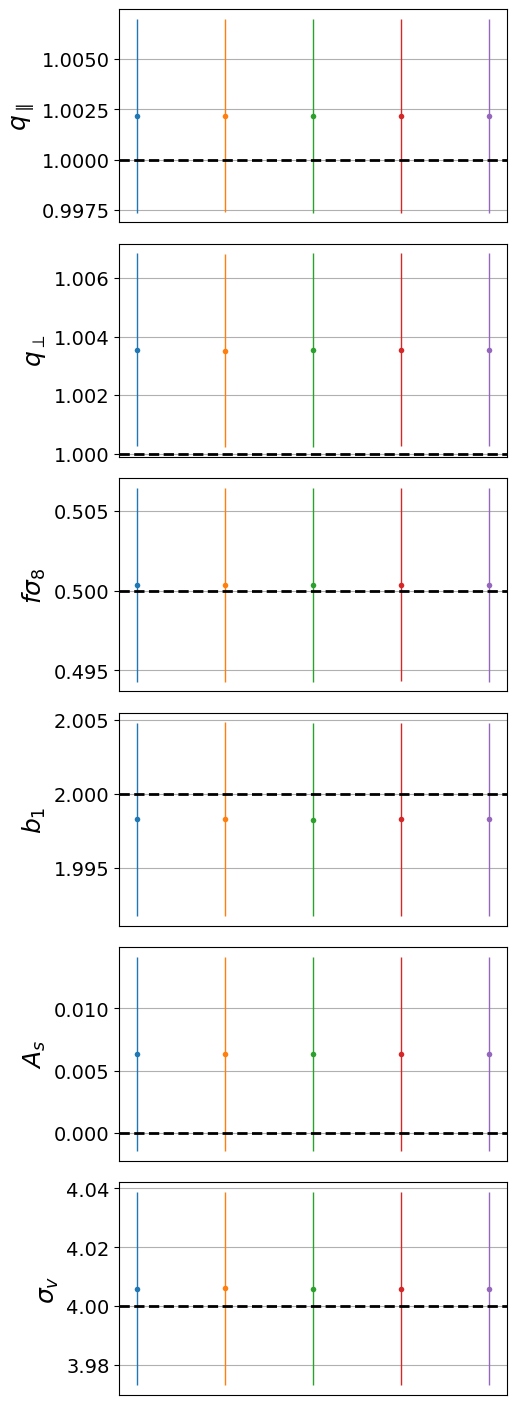

In [7]:
style = ProfilesPlotStyle()
style.plot_aligned_stacked(profiles,truths='value')
plt.show()

## Let's play a bit more: run a sampler (zeus) instead of previous minimizer

In [8]:
# here we replace minuit by some sampler, let's take zeus
with open(config_fn,'r') as file:
    config = file.read()
config_block = yaml_parser(config)
config_block['mockdata']['mean'] = False
config_block['projection']['$modules'] = []
zeus = {}
zeus['$module_name'] = 'cosmopipe.samplers.ensemble.zeus'
zeus['$modules'] = ['like']
zeus['eigen_gr_stop'] = 0.5
zeus['save'] = '_data/samples_zeus.npy'
config_block['zeus'] = zeus
config_block['fitting']['$modules'] = ['zeus'] # we replace minuit (and plotting) by zeus
main(config_block=config_block)

[000011.73] [0/1] 08-02 00:08  BasePipeline              INFO     Init module BasePipeline [main].
[000011.74] [0/1] 08-02 00:08  BaseModule                INFO     Importing module cosmopipe.theory.primordial.primordial [primordial].
[000011.77] [0/1] 08-02 00:08  BaseModule                INFO     Found description file /local/home/adematti/Bureau/DESI/NERSC/cosmopipe/cosmopipe/theory/primordial/primordial.yaml.
[000011.77] [0/1] 08-02 00:08  BaseModule                INFO     Init module Primordial [primordial].
[000011.77] [0/1] 08-02 00:08  BaseModule                INFO     Importing module cosmopipe.theory.galaxy_clustering.linear_model [model].
[000011.79] [0/1] 08-02 00:08  BaseModule                INFO     Found description file /local/home/adematti/Bureau/DESI/NERSC/cosmopipe/cosmopipe/theory/galaxy_clustering/linear_model.yaml.
[000011.79] [0/1] 08-02 00:08  BaseModule                INFO     Init module LinearModel [model].
[000011.79] [0/1] 08-02 00:08  BaseModule       

/local/home/adematti/Bureau/DESI/NERSC/lib/cosmoprimo/cosmoprimo/eisenstein_hu.py:20: UserWarning: EisensteinHuEngine cannot cope with massive neutrinos
  warnings.warn('{} cannot cope with massive neutrinos'.format(self.__class__.__name__))


[000012.38] [0/1] 08-02 00:08  MockDataVector            INFO     Saving to _data/data.txt.
[000012.40] [0/1] 08-02 00:08  GaussianLikelihood        INFO     The number of observations used to estimate the covariance matrix is not provided, hence no Hartlap factor is applied to inverse covariance.
[000012.40] [0/1] 08-02 00:08  ZeusSampler               INFO     Varying parameters ['effect_ap.qpar', 'effect_ap.qperp', 'galaxy_rsd.fsig', 'galaxy_bias.b1', 'galaxy_bias.As', 'galaxy_bias.sigmav'].
[000012.49] [0/1] 08-02 00:08  root                      INFO     Initialising ensemble of 16 walkers...
[000053.06] [0/1] 08-02 00:09  ZeusSampler               INFO     Sampling has run for 100 iterations.
[000053.07] [0/1] 08-02 00:09  ZeusSampler               INFO     Diagnostics:
[000053.08] [0/1] 08-02 00:09  ZeusSampler               INFO     - max eigen Gelman-Rubin - 1 is 0.349 < 0.5.
[000053.10] [0/1] 08-02 00:09  ZeusSampler               INFO     - max diag Gelman-Rubin - 1 is 0.052

In [9]:
from cosmopipe.lib.samples import Samples, SamplesPlotStyle
samples = Samples.load('_data/samples_zeus.npy')
samples = samples.remove_burnin(0.6)

[000090.73] [0/1] 08-02 00:10  Samples                   INFO     Loading _data/samples_zeus.npy.


[000092.30] [0/1] 08-02 00:10  matplotlib.mathtext       INFO     Substituting symbol \perp from STIXGeneral
[000092.32] [0/1] 08-02 00:10  matplotlib.mathtext       INFO     Substituting symbol \perp from STIXGeneral
[000092.46] [0/1] 08-02 00:10  matplotlib.mathtext       INFO     Substituting symbol \perp from STIXGeneral
[000092.46] [0/1] 08-02 00:10  matplotlib.mathtext       INFO     Substituting symbol \perp from STIXGeneral
[000092.90] [0/1] 08-02 00:10  matplotlib.mathtext       INFO     Substituting symbol \perp from STIXGeneral
[000092.93] [0/1] 08-02 00:10  matplotlib.mathtext       INFO     Substituting symbol \perp from STIXGeneral
[000093.06] [0/1] 08-02 00:10  matplotlib.mathtext       INFO     Substituting symbol \perp from STIXGeneral
[000093.07] [0/1] 08-02 00:10  matplotlib.mathtext       INFO     Substituting symbol \perp from STIXGeneral


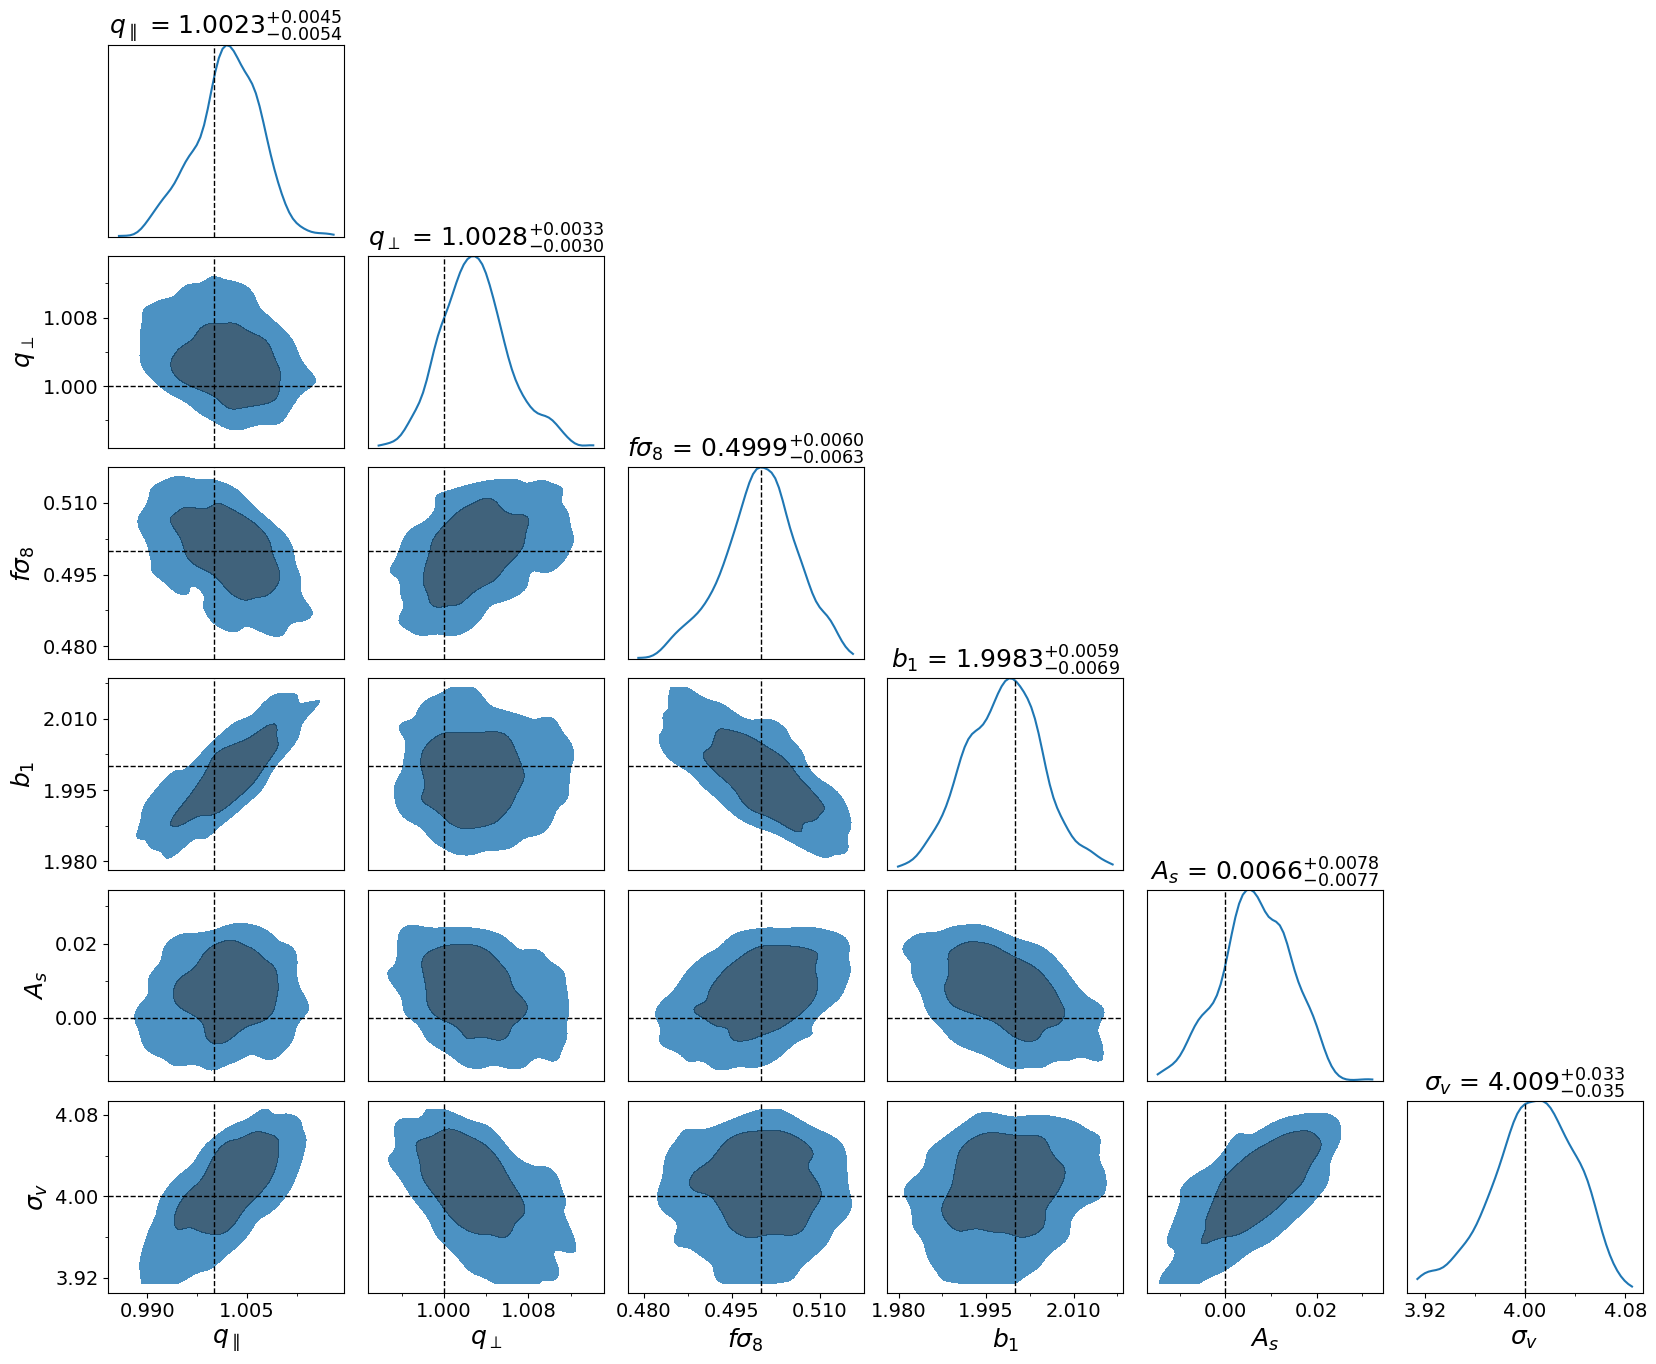

In [10]:
style = SamplesPlotStyle()
style.plot_corner(samples,truths='value')
plt.show()

[000093.58] [0/1] 08-02 00:10  matplotlib.mathtext       INFO     Substituting symbol \perp from STIXGeneral
[000093.58] [0/1] 08-02 00:10  matplotlib.mathtext       INFO     Substituting symbol \perp from STIXGeneral
[000093.92] [0/1] 08-02 00:10  matplotlib.mathtext       INFO     Substituting symbol \perp from STIXGeneral
[000093.92] [0/1] 08-02 00:10  matplotlib.mathtext       INFO     Substituting symbol \perp from STIXGeneral


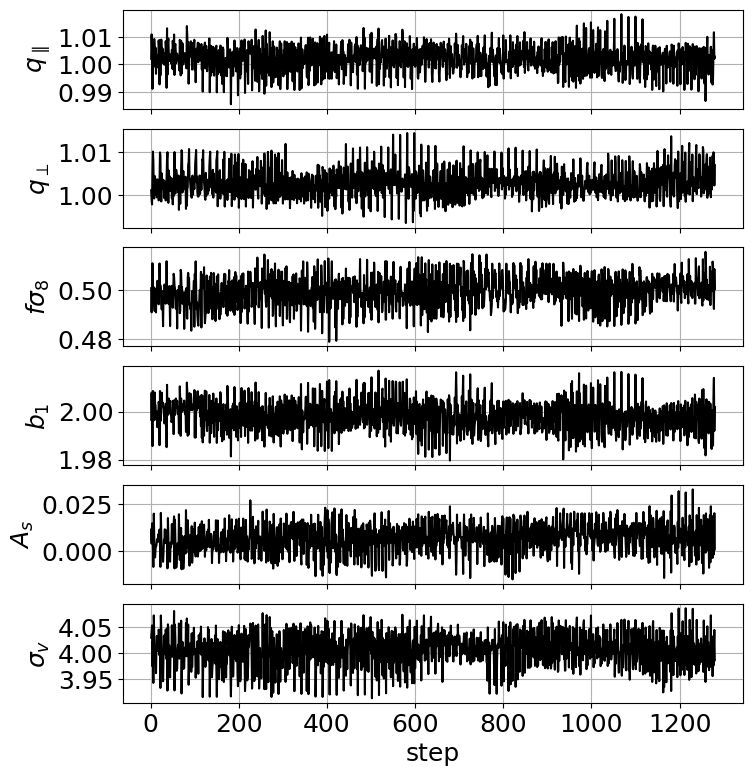

In [11]:
style.plot_chain(samples)
plt.show()